## E4040 2024 Fall Project
### Improving CNN Robustness via CS Shapley Value-guided Augmentation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd

tf.test.gpu_device_name()

'/device:GPU:0'

### Import CIFAR-10 data and training ResNet18

In [2]:
from utils.ResNet18_trainer import ResNet18_trainer, load_cifar10_dataset#, delete_previous_checkpoints

In [3]:
batch_size = 128
lr = 0.1
momentum = 0.9
decay = 0.0005
#log_period = 100
epochs=60
num_classes=10
checkpoint_dir="./checkpoint/ResNet18"
model_path = "./saved_model/ResNet18"

In [4]:
train_ds, test_ds = load_cifar10_dataset(batch_size)

In [5]:
trainer = ResNet18_trainer(
    train_ds=train_ds,
    test_ds=test_ds,
    num_classes=num_classes,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    momentum=momentum,
    decay=decay,
    checkpoint_dir=checkpoint_dir
)

In [6]:
###########
if os.path.exists(checkpoint_dir):
    for filename in os.listdir(checkpoint_dir):
        file_path = os.path.join(checkpoint_dir, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
    print("Deleted previous checkpoints.")
    

Deleted previous checkpoints.


In [7]:
trainer.run()

No checkpoint found. Starting from scratch.
Training Epoch 1
Epoch 1, Loss: 2.0920565128326416, Accuracy: 27.799999237060547, Test Loss: 1.6527928113937378, Test Accuracy: 40.75
Checkpoint saved at: ./checkpoint/ResNet18/ckpt_epoch_1.h5
Training Epoch 2
Epoch 2, Loss: 2.0235111713409424, Accuracy: 31.262001037597656, Test Loss: 1.631805181503296, Test Accuracy: 40.619998931884766
Checkpoint saved at: ./checkpoint/ResNet18/ckpt_epoch_2.h5
Training Epoch 3
Epoch 3, Loss: 1.4662601947784424, Accuracy: 46.380001068115234, Test Loss: 1.490518569946289, Test Accuracy: 45.66999816894531
Checkpoint saved at: ./checkpoint/ResNet18/ckpt_epoch_3.h5
Training Epoch 4
Epoch 4, Loss: 1.2165998220443726, Accuracy: 56.4379997253418, Test Loss: 1.1222209930419922, Test Accuracy: 60.40999984741211
Checkpoint saved at: ./checkpoint/ResNet18/ckpt_epoch_4.h5
Training Epoch 5
Epoch 5, Loss: 0.9969229698181152, Accuracy: 64.75, Test Loss: 0.9019384384155273, Test Accuracy: 68.08000183105469
Checkpoint saved a

Epoch 41, Loss: 0.064341701567173, Accuracy: 97.802001953125, Test Loss: 0.4460940659046173, Test Accuracy: 90.27000427246094
Checkpoint saved at: ./checkpoint/ResNet18/ckpt_epoch_41.h5
Training Epoch 42
Epoch 42, Loss: 0.06018419563770294, Accuracy: 97.90800476074219, Test Loss: 0.4505593478679657, Test Accuracy: 89.91000366210938
Checkpoint saved at: ./checkpoint/ResNet18/ckpt_epoch_42.h5
Training Epoch 43
Epoch 43, Loss: 0.05600331351161003, Accuracy: 98.0199966430664, Test Loss: 0.45062246918678284, Test Accuracy: 89.62000274658203
Checkpoint saved at: ./checkpoint/ResNet18/ckpt_epoch_43.h5
Training Epoch 44
Epoch 44, Loss: 0.05354846641421318, Accuracy: 98.0780029296875, Test Loss: 0.5039269328117371, Test Accuracy: 89.79000091552734
Checkpoint saved at: ./checkpoint/ResNet18/ckpt_epoch_44.h5
Training Epoch 45
Epoch 45, Loss: 0.04778524488210678, Accuracy: 98.31999969482422, Test Loss: 0.46824994683265686, Test Accuracy: 90.3800048828125
Checkpoint saved at: ./checkpoint/ResNet18/

In [8]:
if os.path.exists(model_path):
    for filename in os.listdir(model_path):
        file_path = os.path.join(model_pathmodel_path, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
    print("Deleted previous saved models.")

Deleted previous saved models.


In [9]:
trainer.model.save(model_path)
print("Model saved to ./save_model/ResNet18")

INFO:tensorflow:Assets written to: ./saved_model/ResNet18/assets
Model saved to ./save_model/ResNet18


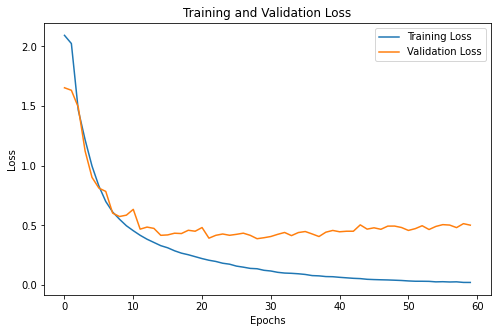

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(trainer.train_loss_history, label='Training Loss')
plt.plot(trainer.test_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

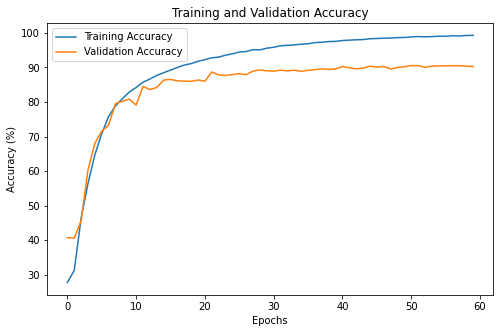

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(trainer.train_accuracy_history, label='Training Accuracy')
plt.plot(trainer.test_accuracy_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Calculation of Shapley values

In [12]:
import os
import tensorflow as tf

#tf.config.set_visible_devices([], 'GPU')
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model
from pathlib import Path
import time
#########from utils.utils import set_seed, cifar10_std, cifar10_mean
from utils.ResNet18_trainer import std, mean
from tensorflow.keras.preprocessing.image import save_img
from utils.ResNet18_trainer import ResNet18_trainer, load_cifar10_dataset

%matplotlib inline
%load_ext autoreload
%autoreload 2

from utils.Shapley_Value_Calculator import getShapley_pixel, getShapley_freq, getShapley_freq_dis, sample_mask, getShapley_freq_softmax, visual_shap


RuntimeError: Visible devices cannot be modified after being initialized

In [2]:
#model_name = 'ResNet18'
#dataset_name = 'cifar10'
#data_path = '~/data'
output_path = './output'
#model_path = "./save_model/ResNet18"
model_path = "./saved_model/ResNet18"
sample_times = 2  #000
#num_per_class = 150
#testdata = False
mask_size = 3 #16
n_per_batch = 1
start_num = 0
get_freq_by_dis = False
fix_mask = False
split_n = 1
static_center = False
#norm = True
batch_size = 64
num_classes=10
seed = 111

tf.random.set_seed(seed)


In [3]:
# Load model
model = tf.keras.models.load_model(model_path, compile=False)


In [4]:
train_ds, test_ds = load_cifar10_dataset(batch_size)

In [18]:
count = [0 for _ in range(num_classes)]

dataset = test_ds

for img, y in dataset:
    bs, w, h, c = img.shape
    img, y = tf.convert_to_tensor(img), tf.convert_to_tensor(y)

    for k in range(bs):
        if count[y[k].numpy()[0]] < 0:
            count[y[k].numpy()[0]] += 1
        elif count[y[k].numpy()[0]] < 50:
            shap_value = getShapley_freq_softmax(
                img, y, model, sample_times, mask_size, k,
                n_per_batch=n_per_batch,
                split_n=split_n,
                static_center=False
            )

            shap_path = os.path.join('', "shap_result", f"{y[k].numpy()[0]}")
            Path(shap_path).mkdir(parents=True, exist_ok=True)
            np.save(os.path.join(shap_path, f"{count[y[k].numpy()[0]]}_freq.npy"), shap_value)

            visual_path = os.path.join(shap_path, f"{count[y[k].numpy()[0]]}_freq_shap.png")
            visual_shap(shap_value, mask_size, mask_size, visual_path)

            raw_img = img[k].numpy()
            img_path = os.path.join(shap_path, f"{count[y[k].numpy()[0]]}.png")
            
            for j in range(3):
                raw_img[:, :, j] = raw_img[:, :, j] * std[j] + mean[j]
            save_img(img_path, raw_img)

            count[y[k].numpy()[0]] += 1
            print(f"Class {y[k].numpy()[0]} sample {count[y[k].numpy()[0]]} completed.")


masked_img: (10, 32, 32, 3)
output: tf.Tensor(
[[0.23004371 0.08545776 0.08545773 0.08545984 0.08547141 0.08546851
  0.08545774 0.08624364 0.08548196 0.08545772]
 [0.23042291 0.08543406 0.08543403 0.08543575 0.08544731 0.08544244
  0.08543404 0.08605764 0.08545781 0.08543402]
 [0.23179635 0.08534768 0.0853477  0.08535112 0.08535769 0.08539087
  0.0853478  0.08535969 0.08535343 0.08534768]
 [0.08670476 0.08670474 0.08670475 0.20824602 0.08671855 0.08680054
  0.09800629 0.08670474 0.08670482 0.08670474]
 [0.08856246 0.08856243 0.08856244 0.14857693 0.08858189 0.08949233
  0.1419742  0.08856243 0.08856256 0.08856243]
 [0.08855362 0.08855359 0.0885536  0.15008233 0.08857064 0.08945534
  0.14056994 0.08855359 0.08855373 0.08855359]
 [0.20484433 0.08692041 0.08693397 0.08700698 0.08738143 0.08692417
  0.09543724 0.0869197  0.09071218 0.08691965]
 [0.21140927 0.08656679 0.08658959 0.08660477 0.08709224 0.0865689
  0.09136546 0.08656618 0.09067071 0.08656615]
 [0.22586733 0.08571618 0.08588831

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([0, 1, 4, 5, 6, 7, 8, 3, 2])

TypeError: 'PrefetchDataset' object does not support indexing

In [16]:
aaa =np.array([2.33248621e-02, 7.49617757e-04, 3.52356344e-01, 2.36003712e-01,
  9.61460173e-02, 2.44320214e-01, 2.27117091e-02, 1.11861918e-02,
  1.22030042e-02, 9.98409465e-04])
bbb = tf.argmax(aaa, axis=-1)
print("bbb:", bbb)


bbb: tf.Tensor(2, shape=(), dtype=int64)


In [15]:
x_test = x_test.astype('float32') / 255.0

In [16]:
predictions = model(x_test)



In [19]:
print(predictions[:10])

tf.Tensor(
[[2.33248621e-02 7.49617757e-04 3.52356344e-01 2.36003712e-01
  9.61460173e-02 2.44320214e-01 2.27117091e-02 1.11861918e-02
  1.22030042e-02 9.98409465e-04]
 [9.09662023e-02 4.22474509e-03 5.70751190e-01 6.26687333e-02
  1.40823543e-01 2.19893865e-02 3.51789556e-02 6.78093778e-03
  6.36044666e-02 3.01178894e-03]
 [7.75583163e-02 1.81420823e-03 5.48251152e-01 1.09931611e-01
  1.37956142e-01 5.25747426e-02 2.28246413e-02 7.12314062e-03
  4.03941609e-02 1.57185376e-03]
 [1.13995209e-01 2.42476771e-03 6.25434279e-01 6.86364323e-02
  8.29450041e-02 2.49087643e-02 2.15078499e-02 5.19478740e-03
  5.29900864e-02 1.96281215e-03]
 [1.78613551e-02 1.25616498e-03 5.21133184e-01 1.04399949e-01
  2.22250283e-01 6.71412796e-02 5.01192883e-02 6.65253447e-03
  8.36848561e-03 8.17465712e-04]
 [3.92282233e-02 2.46568373e-03 5.06564260e-01 1.30733043e-01
  1.67187288e-01 7.40858987e-02 4.40960415e-02 8.33939295e-03
  2.52674446e-02 2.03283480e-03]
 [2.30960790e-02 5.69595257e-04 5.77167809e-01 

In [17]:
# 输出预测结果 (例如显示前10个样本的预测标签)
predicted_labels = predictions.argmax(axis=1)
print(predicted_labels[:10])

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'argmax'

### Reconstructing Shapley Values

In [1]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize
from pathlib import Path
import math
import matplotlib.pyplot as plt
from tensorflow.signal import fft2d, ifft2d
from tensorflow.keras.utils import save_img

ImportError: cannot import name 'save_img'

In [ ]:
path = "your_data_path"
recon_path = os.path.join(path, "reconstruction")
ifft_path = os.path.join(path, "ifft")
shap_path = os.path.join(path, "shap_result")

In [ ]:
os.makedirs(recon_path, exist_ok=True)
os.makedirs(ifft_path, exist_ok=True)

In [ ]:
train_norm = False  # 替代 cfg.train.norm
cifar10_mean = [0.4914, 0.4822, 0.4465]
cifar10_std = [0.2023, 0.1994, 0.2010]

In [ ]:
# 定义数据增强操作
def preprocess_image(img_path):
    img = load_img(img_path)
    img = img_to_array(img) / 255.0
    img = resize(img, [32, 32])  # 假设目标是 CIFAR-10 大小
    return tf.convert_to_tensor(img, dtype=tf.float32)

In [ ]:
# 遍历类文件夹
classes = os.listdir(shap_path)

In [ ]:
# 处理每个类
for class_name in classes:
    result_path = os.path.join(shap_path, class_name)
    if not os.path.isdir(result_path):
        continue

    files = os.listdir(result_path)
    for file in files:
        if ".png" not in file or "shap" in file:
            continue

        # 加载图片
        img_path = os.path.join(result_path, file)
        img = preprocess_image(img_path)

        # FFT 转换
        freq = fft2d(tf.cast(img, tf.complex64))

        # 加载频域 shap 值
        freq_shap_file = file.split('.')[0] + "_freq.npy"
        freq_shap_path = os.path.join(result_path, freq_shap_file)
        freq_shap = np.load(freq_shap_path)
        mask_size = int(math.sqrt(freq_shap.size))
        freq_shap = tf.reshape(freq_shap, [1, mask_size, mask_size])

        # 扩展为多通道
        freq_shap = tf.tile(freq_shap, [3, 1, 1])  # 假设 3 个通道
        freq_shap = tf.image.resize(freq_shap, [img.shape[0], img.shape[1]])

        # 构造正负掩码
        mask_pos = tf.cast(freq_shap > 0, tf.complex64)
        mask_neg = tf.cast(freq_shap < 0, tf.complex64)

        # 去除中心频率
        mask_pos = tf.tensor_scatter_nd_update(
            mask_pos, [[mask_pos.shape[1] // 2, mask_pos.shape[2] // 2]], [0]
        )
        mask_neg = tf.tensor_scatter_nd_update(
            mask_neg, [[mask_neg.shape[1] // 2, mask_neg.shape[2] // 2]], [0]
        )

        # 生成正负频域图片
        pos_freq = freq * mask_pos
        neg_freq = freq * mask_neg

        pos_img = tf.math.real(ifft2d(pos_freq))
        neg_img = tf.math.real(ifft2d(neg_freq))

        # 去标准化
        for c in range(3):
            pos_img[..., c] = pos_img[..., c] * std[c] + mean[c]
            neg_img[..., c] = neg_img[..., c] * std[c] + mean[c]

        # 保存图片
        recon_class_path = os.path.join(recon_path, class_name)
        os.makedirs(recon_class_path, exist_ok=True)
        save_img(os.path.join(recon_class_path, f"{file.split('.')[0]}_pos.png"), pos_img)
        save_img(os.path.join(recon_class_path, f"{file.split('.')[0]}_neg.png"), neg_img)

### Train ResNet18 under AT with CSA